# Computer Vision for Urban Structure Identification
## Technical Report

## Part 1 - EDA

In [1]:
# import libraries
import numpy as np, pandas as pd
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import cv2
import glob
import rasterio as rio
import re

from rasterio import features as RioFeatures
from PIL import Image

data type: uint16
pixel dimensions: (650, 650)


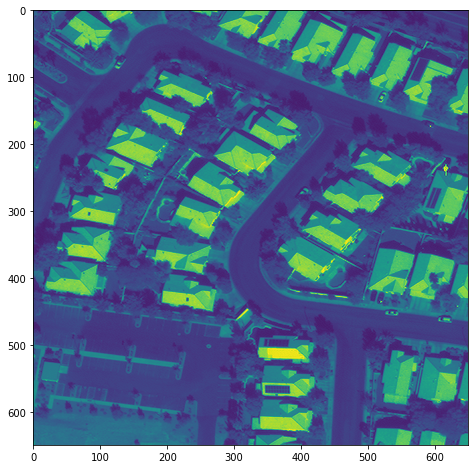

In [2]:
# taking a look at sample raster image

image = cv2.imread('../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img96.tif', -1)

print(f"data type: {image.dtype}")
print(f"pixel dimensions: {image.shape}")

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.show;

In [3]:
# checking image array; not 0 to 255 pixel values
image

array([[ 638,  607,  538, ...,  367,  320,  355],
       [ 585,  617,  616, ...,  331,  348,  364],
       [ 570,  579,  635, ...,  332,  332,  303],
       ...,
       [1249, 1123, 1040, ..., 1135, 1157, 1157],
       [1292, 1291, 1121, ..., 1122, 1175, 1199],
       [ 947, 1180,  965, ..., 1120, 1120, 1154]], dtype=uint16)

In [4]:
# checking image data format
# single-band image format with pixels ranging from 0 to 2047

check_pixels = set()
for row in image:
    for pixel in row:
        check_pixels.add(pixel)
        
print(max(check_pixels))
print(min(check_pixels))

2047
1


In [6]:
# looking at mask images from geojson files
# assigning to geodataframe

gdf = gpd.read_file('../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img96.geojson')
gdf.head(2)

# vector data in last column, 'geometry'

,OBJECTID,FID_VEGAS_,Id,FID_Vegas,Name,AREA,Shape_Leng,Shape_Le_1,SISL,OBJECTID_1,Shape_Le_2,Shape_Le_3,Shape_Area,partialBuilding,partialDec,geometry
0,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000591,0.0,1.0,0.390131,"POLYGON Z ((-115.30424 36.19679 0.00000, -115...."
1,0,0,0,0,None,0.0,0.0,0.0,0.0,0,0.0,0.000541,0.0,1.0,0.249337,"POLYGON Z ((-115.30420 36.19674 0.00000, -115...."


POLYGON Z ((-115.30424136099998 36.19679043600007 0, -115.30424889485622 36.1967426998662 0, -115.30439176267218 36.1967426998662 0, -115.30438194799996 36.19680488600005 0, -115.30424136099998 36.19679043600007 0))


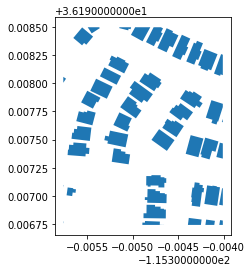

In [7]:
# taking a look at one building raw coordinates
print(gdf['geometry'][0])

# plotting out mask corresponding to above image
gdf.plot();

## Part 2 - Feature Extraction

#### Inspecting Folder Structure

In [9]:
# assigning directories to vars
direct_geojson = '../data/AOI_2_Vegas_Train/geojson/buildings/*.geojson'
direct_tifs = '../data/AOI_2_Vegas_Train/PAN/*.tif'

# create file lists
raw_images = glob.glob(direct_tifs)
raw_masks = glob.glob(direct_geojson)

# confirming number of files
print(len(raw_images))
print(len(raw_masks))    

3851
3851


In [10]:
# checking files in directory; file order not matching
raw_images[:5]

['../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img5977.tif',
 '../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img697.tif',
 '../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img4499.tif',
 '../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img1287.tif',
 '../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img3484.tif']

In [11]:
raw_masks[:5]

['../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1650.geojson',
 '../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img3030.geojson',
 '../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img1728.geojson',
 '../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img5404.geojson',
 '../data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img4897.geojson']

In [12]:
# img/label file numbers do not ascend in regular sequence so we must extract index list
index_list = []
for i in raw_images:
    index_list.append(int(re.findall(r"img(.\d*)", i)[0])) #accessing file numbers with regex
    
# sorted index list
index_list.sort()
index_list[:10]

[1, 3, 4, 7, 8, 9, 10, 12, 13, 14]

#### Importing Image Data

In [14]:
# feature extraction using index_list to append from directory
images = []
for i in index_list:
    images.append(cv2.imread(f'../data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img{i}.tif',-1))
    
images.shape

AttributeError: 'list' object has no attribute 'shape'

#### Importing Mask Data

In [12]:
# defining function to convert vector formatted labels to rasters

def mask_rasterize(mask_index):
    
    # assign inputs from index
    vector_mask = gpd.read_file(f'data/AOI_2_Vegas_Train/geojson/buildings/buildings_AOI_2_Vegas_img{mask_index}.geojson')
    geometry = [shape for shape in vector_mask.geometry]
    raster_image = rio.open(f'data/AOI_2_Vegas_Train/PAN/PAN_AOI_2_Vegas_img{mask_index}.tif')

    rasterized_mask = RioFeatures.rasterize(geometry, # using rasterio.features
                               out_shape=raster_image.shape, # using shape from raster
                               fill=0,
                               out=None,
                               transform=raster_image.transform, # transform to raster specs
                               all_touched=False,
                               default_value=1,
                               dtype=None)
    
    return list(rasterized_mask)

In [14]:
# looping through index list to populate labels list
# some geojson files are empty as no buildings exist in region to be labelled
# this causes an error, so append 650x650 array of 0s to list (all negative class)
masks = []
for i in index_list:
    try:
        masks.append(mask_rasterize(i))  
    except:
        masks.append(np.zeros((650,650)))
        
masks.shape

#### Converting Images and Masks to PNG

In [70]:
# function to convert mask to png format for easy handling

def maskBinary_to_PNG(mask):
    png_mask=[]
    for row in mask:
        png_mask.append([255 if num == 1 else 0 for num in row])
        
    return np.array(png_mask, dtype='uint8')

In [62]:
# function to convert TIFF images to png format for easy handling

def imageTiff_to_PNG(image):
    png_img = []

    for row in image:
        png_row = []

        for pixel in row:
            pixel = int((pixel/2047) * 255)
            png_row.append(pixel)

        png_img.append(png_row)
        
    return np.array(png_img, dtype='uint8')

In [78]:
# processing images and masks and save into clean directory
# note that this step presents a significant bottleneck due to pixel-wise image transformation

for i, image in enumerate(images):
    png = imageTiff_to_PNG(image)
    png = cv2.resize(png, (256,256))
    cv2.imwrite(f"data/images_masks/images/image_{i}.png", png)
    
for i, mask in enumerate(masks):
    png = maskBinary_to_PNG(mask)
    png = cv2.resize(png, (256,256))
    cv2.imwrite(f"data/images_masks/masks/mask_{i}.png", png)

## Part 3 - Modeling
See attached document

## Part 4 - Model Testing

(588, 575)


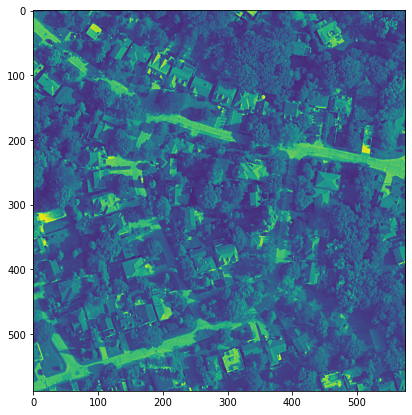

In [93]:
test_image = np.array(cv2.imread('data/test_images/test_img_1.png', 0))

print(test_image.shape)

plt.figure(figsize=(7,7))
plt.imshow(test_image)
plt.show()

In [96]:
test_img_3chan = cv2.cvtColor(test_image)

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'cvtColor'
> Overload resolution failed:
>  - cvtColor() missing required argument 'code' (pos 2)
>  - cvtColor() missing required argument 'code' (pos 2)


In [95]:
test_image = np.expand_dims(test_image, axis=2)
test_image.shape

(588, 575, 1)

In [179]:
def image_transform(img_path):

    # importing image as grayscale
    img = cv2.imread('data/test_images/test_img_2.png', 0)
    print(img.shape)

    # crop image
    x = img.shape[0]
    y = img.shape[1]
    cropped_img = img[0:min(x,y), 0:min(x,y)]

    # resize image
    resize_img = cv2.resize(cropped_img, (256,256))

    # transform image to 3-channel grayscale, to satisfy model's dimension requirements
    # this code was modified from Mona Jalal
    # https://askubuntu.com/questions/1091493/convert-a-1-channel-image-to-a-3-channel-image
    img_out = np.zeros((256,256,3), dtype='int')
    img_out[:,:,0] = resize_img
    img_out[:,:,1] = resize_img
    img_out[:,:,2] = resize_img
    
    return img_out

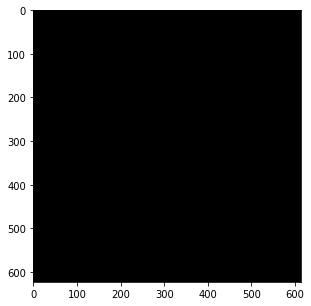

(623, 613, 3)


In [166]:
img = cv2.imread('data/test_images/test_img_2.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = np.zeros_like(img)
# img2[:,:,0] = gray
# img2[:,:,1] = gray
# img2[:,:,2] = gray
# cv2.imwrite('10524.jpg', img2)

plt.figure(figsize=(5,5))
plt.imshow(img2)
plt.show()

print(img2.shape)